## Final Project Submission

* Student name: Samuel Marder
* Student pace: Flex-20 week
* Blog post URL:

## Overview

We are looking at data across all states and DC to determine what causes customers to churn so we could better inform our sales strategy towards customer retention.

# Data import

In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, \
recall_score, classification_report, make_scorer, roc_curve, auc, roc_auc_score

In [37]:
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Most of the scatter plots do not look like this which is why I did not go with any logistic regression model in machine learning section

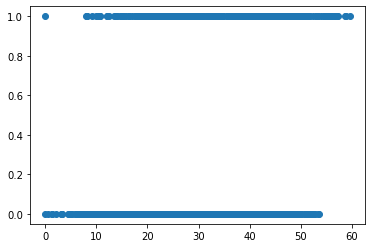

In [39]:
plt.scatter(df["total day charge"], df['churn']) ;

In [40]:
print(df['churn'].value_counts())
print()
print(df['area code'].value_counts())
print()
print(df['international plan'].value_counts())
print()
print(df['voice mail plan'].value_counts())

False    2850
True      483
Name: churn, dtype: int64

415    1655
510     840
408     838
Name: area code, dtype: int64

no     3010
yes     323
Name: international plan, dtype: int64

no     2411
yes     922
Name: voice mail plan, dtype: int64


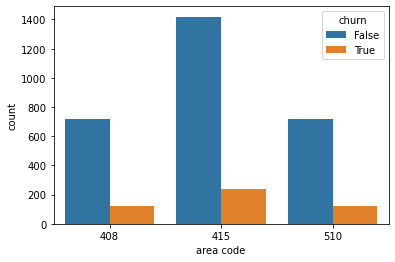

In [41]:
ac_df = df.groupby(["area code", "churn"]).size().reset_index(name='count')
sns.barplot(x=ac_df["area code"], y=ac_df['count'], hue=ac_df["churn"]);

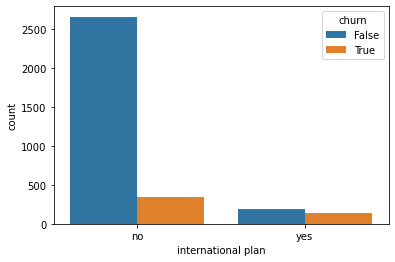

In [42]:
ip_df = df.groupby(["international plan", "churn"]).size().reset_index(name='count')
sns.barplot(x=ip_df["international plan"], y=ip_df['count'], hue=ip_df["churn"]);

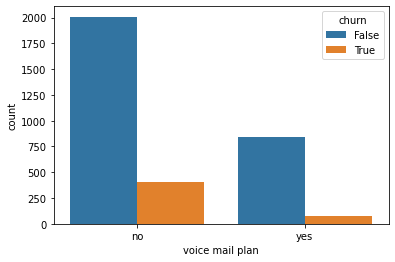

In [43]:
vmp_df = df.groupby(["voice mail plan", "churn"]).size().reset_index(name='count')
sns.barplot(x=vmp_df["voice mail plan"], y=vmp_df['count'], hue=vmp_df["churn"]);

## Data Transformation

In [44]:
def plan_to_num(plan):
    if plan == "yes":
        return 1
    elif plan == "no":
        return 0
    return plan

In [45]:
df['international plan'] = df['international plan'].apply(plan_to_num)
df['voice mail plan'] = df['voice mail plan'].apply(plan_to_num)

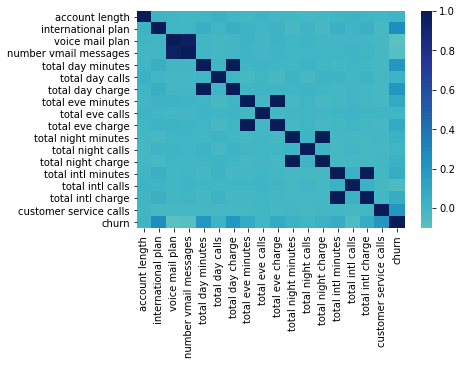

In [46]:
sns.heatmap(df.drop(['state', 'phone number', 'area code'], axis=1).corr(), center=0, cmap="YlGnBu");

## Data split

In [47]:
X = df.drop(['churn'], axis=1)
y = df['churn']

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   int64  
 5   voice mail plan         3333 non-null   int64  
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

Preparing the data for machine learning process

In [49]:
X.drop(['phone number'], axis=1, inplace=True)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=314159)

Transforming the data using SMOTE to account for the imbalance in data

In [51]:
X_train_resampled, y_train_resampled = SMOTENC(random_state=314159, categorical_features=[0, 2])\
    .fit_resample(X_train, y_train)
print(y_train.value_counts())
print()
print(y_train_resampled.value_counts())

False    2138
True      361
Name: churn, dtype: int64

True     2138
False    2138
Name: churn, dtype: int64


In [54]:
ohe = OneHotEncoder(sparse=False)
train_transform = ohe.fit_transform(X_train_resampled[['state', 'area code']], y_train_resampled)
columns = np.concatenate((ohe.categories_[0], ohe.categories_[1].astype(str)))
train_ohe_df = pd.DataFrame(
    train_transform,
    columns=columns,
    index=X_train_resampled.index
)
X_train_resampled = pd.concat([X_train_resampled.drop(['state', "area code"], axis=1), train_ohe_df], axis=1)

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', '408', '415', '510'],
      dtype=object)

In [55]:
test_transform = ohe.transform(X_test[['state', 'area code']])
columns = np.concatenate((ohe.categories_[0], ohe.categories_[1].astype(str)))
test_ohe_df = pd.DataFrame(
    test_transform,
    columns=columns,
    index=X_test.index)

X_test.drop(["state", "area code"], axis=1, inplace=True)
X_test = pd.concat([X_test, test_ohe_df], axis=1)

C:\Users\smard\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Classify data

In [56]:
recall_scorer = make_scorer(recall_score)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834 entries, 1049 to 1614
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          834 non-null    int64  
 1   international plan      834 non-null    int64  
 2   voice mail plan         834 non-null    int64  
 3   number vmail messages   834 non-null    int64  
 4   total day minutes       834 non-null    float64
 5   total day calls         834 non-null    int64  
 6   total day charge        834 non-null    float64
 7   total eve minutes       834 non-null    float64
 8   total eve calls         834 non-null    int64  
 9   total eve charge        834 non-null    float64
 10  total night minutes     834 non-null    float64
 11  total night calls       834 non-null    int64  
 12  total night charge      834 non-null    float64
 13  total intl minutes      834 non-null    float64
 14  total intl calls        834 non-null  

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_cv_score = cross_val_score(dt_clf, X_train_resampled, y_train_resampled, scoring=recall_scorer)
mean_dt_cv_score = dt_cv_score.mean()

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 12, 18, 24, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [ ]:
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, scoring=recall_scorer)

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

dt_y_score = dt_grid_search.predict_proba(X_test)[:, 1]

print(f"Training Recall Score: {dt_grid_search.best_score_ :.2%}")
print(f"Test Recall Score: {dt_gs_testing_score :.2%}")

print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

In [ ]:
dt_estimator = dt_grid_search.best_estimator_
dt_pred = dt_estimator.predict(X_test)
print(classification_report(y_test, dt_pred))
fpr, tpr, thresholds = roc_curve(y_test, dt_y_score)
print('AUC for DT: {}'.format(auc(fpr, tpr)))

In [ ]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train_resampled, y_train_resampled, scoring=recall_scorer))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

In [ ]:
rf_param_grid = {'bootstrap': [True, False],
                 'max_depth': [6, 12, 18, 24, 30],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
}

In [ ]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, scoring=recall_scorer)

rf_grid_search.fit(X_train_resampled, y_train_resampled)

rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

rf_y_score = rf_grid_search.predict_proba(X_test)[:, 1]

print(f"Training Recall Score: {rf_grid_search.best_score_ :.2%}")
print(f"Testing Recall: {rf_gs_testing_score :.2%}")
print("")
print("Best Parameter Combination Found During Grid Search:")
rf_grid_search.best_params_

In [ ]:
rf_estimator = rf_grid_search.best_estimator_
rf_pred = rf_estimator.predict(X_test)
print(classification_report(y_test, rf_pred))
fpr, tpr, thresholds = roc_curve(y_test, rf_y_score)
print('AUC for RF: {}'.format(auc(fpr, tpr)))

In [ ]:
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

In [ ]:
rf_fi = rf_estimator.feature_importances_
dt_fi = dt_estimator.feature_importances_

In [ ]:
rf_dict = dict(zip(X_test.columns, rf_fi))
df_dict = dict(zip(X_test.columns, dt_fi))
joined = {}
for key in X_test.columns:
    joined[key] = [rf_dict[key], df_dict[key]]

In [ ]:
j = pd.DataFrame.from_dict(joined).transpose()
j.columns = ["Random Forest", "Decision Tree"]
pd.set_option('display.max_rows', len(X_test.columns))
j

In [ ]:
plot_confusion_matrix(dt_estimator, X_test, y_test);

In [ ]:
plot_confusion_matrix(rf_estimator, X_test, y_test);